## Purpose: Simulating multivariate distributions and inducing correlations

### Update: 01/24/2017:

1. This process has the problem of creating ranks with replacement, and so ultimately we end up dropping some draws
2. If cor(X,Y*) = 0.7, and cor(Y*,Z*) = 0.7, then we see that cor(X*,Z*)=0.7

In [1]:
require(VineCopula)
require(copula)
require(ggplot2)
require(ggExtra)
require(gridExtra)
require(dplyr)


## Resizing notebook plot space
options(repr.plot.width=8, repr.plot.height=5)

Loading required package: VineCopula
Loading required package: copula
Loading required package: ggplot2
Loading required package: ggExtra
Loading required package: gridExtra
Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



### Simulate (independent) standard normal distributions

In [2]:
# Distribution parameters
N = 10000
mu = 0
sigma = 1

# The correlation we want to induce 
rho = 0.7

In [3]:
set.seed(123)
X <- rnorm(N, mu, sigma)
Y <- rnorm(N, mu, sigma)
Z <- rnorm(N, mu, sigma)

head(data.frame(index = c(1:N),X= X,Y= Y,Z= Z))

index,X,Y,Z
1,-0.56047565,2.3707252,-0.8362967
2,-0.23017749,-0.1668120,-0.2205730
3,1.55870831,0.9269614,-2.1035148
4,0.07050839,-0.5681517,-1.6678075
5,0.12928774,0.2250901,-1.0979629
6,1.71506499,1.1319859,-1.6656212


## Use a copula to jointy correlate X, Y and Z, and create newly sorted variables

#### This function takes a correlation parameter (vector) and the number of draws to simulate, and returns a data frame with the index of the draws to arrange by in order to achieve the specified correlation, and also the sorted data using those indices

In [10]:
## Checking the original existing correlation
cor(cbind(X, Y, Z), method = "spearman")

,X,Y,Z
X,1.00000000,0.0103485226,0.0169983371
Y,0.01034852,1.0000000000,0.0001936581
Z,0.01699834,0.0001936581,1.0000000000


In [9]:
## Use a 0.7 cross-correlation  
corr_vector <- c(0.7, 0.7, 0.7)

### NOTE: the normalCopula function takes a vector of parameters, such that 
## if corr <- c(A, B, C), then the number A corresponds to the correlation b/w the first two variables of data, 
## B for corr b/w second and third, C for corr b/w third and first

### Creating a function which will take a N dim data frame and sort.... hope it works

In [91]:
create_corr_indices <- function(corr, draws, data) {

    ## How many variables are we dealing with?
        dim = length(corr)
    
    ## Break if number of element in correlation vector is not equal to the number of columns
        if (dim > 1) {
            stopifnot(dim == dim(data)[2])
            str <- "un"
            dim_c <- dim
        }
        if (dim == 1) {
            str <- "un"
            dim_c <- 2
        }
        
    
        print(cop_object_1 <- normalCopula(param = corr, dim = dim_c, dispstr = paste0(str)))
        cop_draws_1 <- rCopula(n = draws, copula = cop_object_1)
 
    ## Convert the bivariate distribution into indices (multiply by 1000, and round to integers)
        cop_indices_1 <- data.frame(ceiling(draws*cop_draws_1))
  
    # Bounding if any value is above the highest number
        for(i in 1:dim_c) {
          cop_indices_1[,i] <- ifelse(cop_indices_1[,i]>draws, draws, cop_indices_1[,i])
        }
    
    ## Let the first column be the baseline index in the copula; sort the baseline column
        cop_indices_1 <- arrange(cop_indices_1, cop_indices_1[,1])
    
    #### Take our marginals we previously made, and arrange them separately
        sorted_data <- list()
        for(i in c(1:dim_c)) {
            sorted_data[[i]] <-sort(data[,i])
        }
        sorted_data_df <- as.data.frame(sorted_data)
        colnames(sorted_data_df) <- paste0("var_",c(1:dim_c))

#         X_sorted <- sort(data[,1])
#         Y_sorted <- sort(data[,2])
#         Z_sorted <- sort(data[,3])

    #### Loop over the copula index data frame and create a joint distribution of X and Y with those indices
        joint_sorted <- data.frame()

        for(i in c(1:draws)) {
          for(j in c(1:dim_c)) {
            joint_sorted[i,j] = sorted_data_df[cop_indices_1[i,j], j]
            }
        }
    
    
    print("New Spearman Correlation Matrix:")
    print(cor(joint_sorted , method = "spearman"))
    
    return(list(copula_index = cop_indices_1, data = joint_sorted ))
}

### Use this function on the joint 3-D data of marginals (X, Y, Z)

In [97]:
tri_copula <- create_corr_indices(corr_vector, draws = N, data = cbind(X, Y, Z))
XYZ_copula_indices <- tri_copula$copula_index
XYZ_all_joint <- tri_copula$data
colnames(XYZ_copula_indices) <- c("X_index", "Y_index", "Z_index")
colnames(XYZ_all_joint) <- c("X_sorted", "Y_sorted", "Z_sorted")
head(cbind(XYZ_copula_indices,XYZ_all_joint))

Normal copula, dim. d = 3 
Dimension:  3 
Parameters:
  rho.1   = 0.7
  rho.2   = 0.7
  rho.3   = 0.7
dispstr:  un 
[1] "New Spearman Correlation Matrix:"
          V1        V2        V3
V1 1.0000000 0.6822434 0.6792089
V2 0.6822434 1.0000000 0.6822313
V3 0.6792089 0.6822313 1.0000000


X_index,Y_index,Z_index,X_sorted,Y_sorted,Z_sorted
1,450,149,-3.845320,-1.6966194,-2.178121
4,29,75,-3.402024,-2.7837200,-2.411279
4,70,47,-3.402024,-2.4249816,-2.529801
5,747,69,-3.289376,-1.4633217,-2.445715
6,1655,116,-3.262149,-0.9701652,-2.260305
7,151,9,-3.189186,-2.1677139,-2.970882


### Plots are always helpful

#### Plots of pairwise sorts

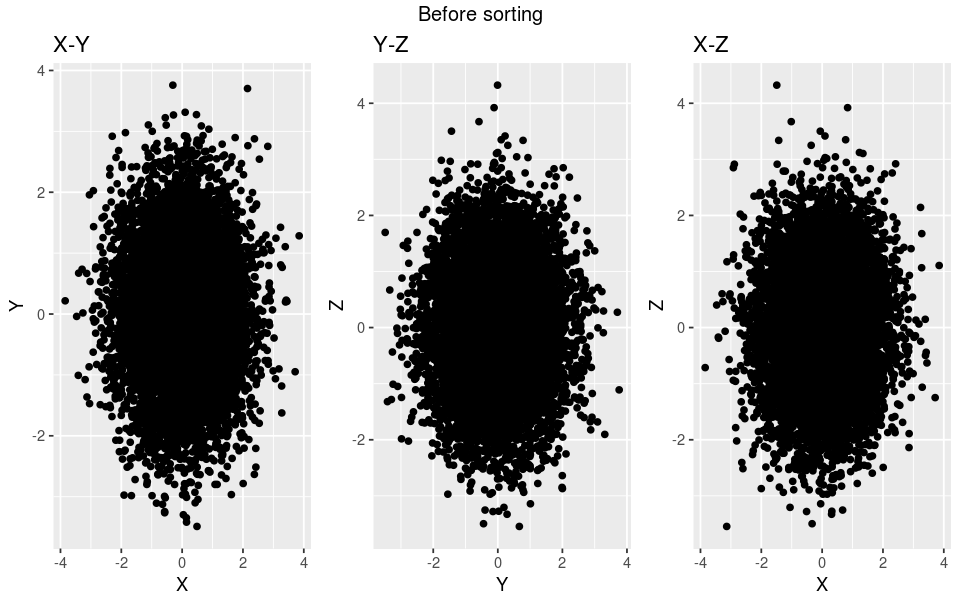

In [94]:
XY_pre<-ggplot(data=data.frame(cbind(X,Y))) + geom_point(aes(x=X,y=Y)) + ggtitle("X-Y")
YZ_pre<-ggplot(data=data.frame(cbind(Z,Y))) + geom_point(aes(x=Y,y=Z)) + ggtitle("Y-Z")
XZ_pre<-ggplot(data=data.frame(cbind(X,Z))) + geom_point(aes(x=X,y=Z)) + ggtitle("X-Z")

grid.arrange(XY_pre, YZ_pre, XZ_pre, nrow=1, top = "Before sorting")

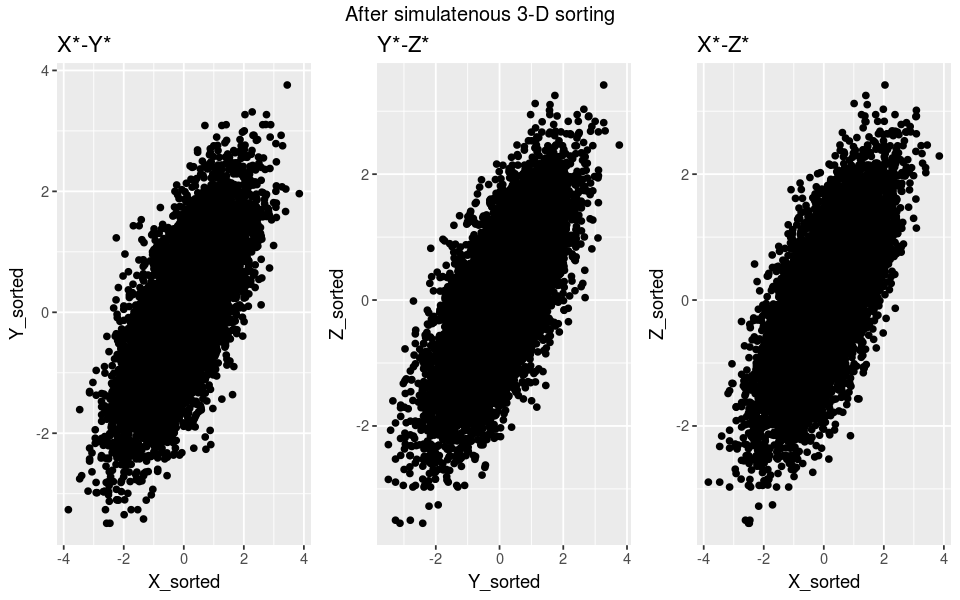

In [96]:
XY_tri_post<-ggplot(data=XYZ_all_joint ) + geom_point(aes(x=X_sorted,y=Y_sorted)) + ggtitle("X*-Y*")
YZ_tri_post<-ggplot(data=XYZ_all_joint ) + geom_point(aes(x=Y_sorted,y=Z_sorted)) + ggtitle("Y*-Z*")
XZ_tri_post<-ggplot(data=XYZ_all_joint ) + geom_point(aes(x=X_sorted,y=Z_sorted)) + ggtitle("X*-Z*")

grid.arrange(XY_tri_post, YZ_tri_post, XZ_tri_post, nrow=1, top = "After simulatenous 3-D sorting")